<a href="https://colab.research.google.com/github/MerylAhounou/Segmentation-s-mantique-avec-U-net/blob/main/Segmentation_s%C3%A9mantique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Chargement des librairies

In [ ]:
%pip install pynrrd

In [ ]:
%pip install pydicom

     |████████████████████████████████| 2.0 MB 5.4 MB/s 


In [ ]:
import os 

import matplotlib.pyplot as plt
import numpy as np 
import nrrd as nd
import pandas as pd 
import random 
import tensorflow as tf


from tqdm import tqdm_notebook, tnrange
import matplotlib.patches as mpatches
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from pydicom import dcmread 
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow import image
from tensorflow.keras import backend as K
from enum import Enum
from PIL import Image

# Constantes

In [ ]:
INPUTS_PATH = "/content/drive/MyDrive/Segmentation sémantique/Inputs"
OUTPUTS_PATH = "/content/drive/MyDrive/Segmentation sémantique/Outputs"

# La taille de l'image doit etre multiple de 16 parce que la première couche de convolution à des filtres de taille 16
IMAGE_HEIGHT = 128
IMAGE_WIDHT = 128

NUM_CLASSES = 2

# Fonctions

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

In [ ]:
def get_unet(input_img, n_filters = 32, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(NUM_CLASSES, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs], name="U-net")
    return model

In [ ]:
def encode_masks(img, img_int):
    """
    Encode img for each class

    Parameters:
    ----------
    img (np.array): image array

    Return:
    ------
    mask (np.array)
    """
    img = np.squeeze(img).T
    img_int = np.squeeze(img_int) * 255

    for x,y in [(x,y) for x in range(img_int.shape[0]) for y in range(img_int.shape[1])]:
              j = img_int[x,y]
              if j > 255:
                img_int[x,y] = 255
              elif j in range(1,5):
                img_int[x,y] = 5
              else:
                img_int[x,y] = img_int[x,y] 

    
    dim = len(img.shape)
    if dim == 2:
      # on ramène toutes les valeurs de pixel représentant le foie (1,4) à 1 pour que après le resize on puisse différencier la lésion qui aura pour valeur de pixel 2
      for x,y in [(x,y) for x in range(img.shape[0]) for y in range(img.shape[1])]:
              j = img[x,y]
              if j == 4 or j == 1:
                img[x,y] = 1
              else:
                img[x,y] = img[x,y] 
      img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDHT), Image.NEAREST, mode = 'constant', preserve_range = True)

      mask = np.zeros((img.shape[0], img.shape[1], NUM_CLASSES))
      mask[:, :, 0] = img_int
      # mask[:, :, 1] = img_int
      # mask[:, :, 2] = img_int
      # mask[:, :, 3] = img_int

      for x,y in [(x,y) for x in range(img.shape[0]) for y in range(img.shape[1])]:
        j = img[x,y]
        if j == 0:
          k = 0
        elif j < 2 and j > 0:
          k = 1
        elif j >=2:
          k = 2



        # Vide
        # if k == 0:
        #   mask[x, y, 0] = 0
        #   mask[x, y, 1] = 0
        #   mask[x, y, 2] = 0
        # Lésion
        if k > 1:
          mask[x, y, 0] = 0
          mask[x, y, 1] = 1
          # mask[x, y, 2] = 1
          # mask[x, y, 3] = 0
        # Foie
        elif k == 1:
          mask[x, y, 0] = 1
          mask[x, y, 1] = 0
          # mask[x, y, 2] = 0
          # mask[x, y, 3] = 0

    elif dim == 3:
      mask = np.zeros((img.shape[0], img.shape[1], NUM_CLASSES))
      mask[:, :, 0] = img_int
      # mask[:, :, 1] = img_int
      # mask[:, :, 2] = img_int
      # mask[:, :, 3] = img_int
      
      # on ramène toutes les valeurs de pixel représentant le foie (1,4) à 1 pour que après le resize on puisse différencier la lésion qui aura pour valeur de pixel 2
      for x,y in [(x,y) for x in range(img.shape[1]) for y in range(img.shape[2])]:
        j = img[0,x,y]
        p = img[1,x,y]
        j += p
        if j == 4 or j == 1:
          img[0,x,y] = 0
          img[1,x,y] = 1
        else:
          img[0,x,y] = img[0,x,y]
          img[1,x,y] = img[1,x,y]
      img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDHT), Image.NEAREST, mode = 'constant', preserve_range = True)

      for x,y in [(x,y) for x in range(img.shape[1]) for y in range(img.shape[2])]:
        j = img[0,x,y]
        p = img[1,x,y]
        j += p

        if j == 0:
          k = 0
        elif j <2  and j > 0:
          k = 1
        elif j >=2:
          k = 2

        # Vide
        # if k == 0:
        #   mask[x, y, 0] = 0
        #   mask[x, y, 1] = 0
        #   mask[x, y, 2] = 0
        # Lésion
        if k > 1:
          mask[x, y, 0] = 0
          mask[x, y, 1] = 1
          # mask[x, y, 2] = 1
          # mask[x, y, 3] = 0
        # Foie
        elif k == 1:
          mask[x, y, 0] = 1
          mask[x, y, 1] = 0
          # mask[x, y, 2] = 0
          # mask[x, y, 3] = 0
    mask /= 255
    return mask 

In [59]:
def encode_preds(img):
    """
    Encode img_final pred for each class
    black for nothing
    green for the liver
    purple for the lesion 
    red for the rib cage section
    
    Parameters:
    ----------
    img (np.array): image array

    Return:
    ------
    img_final (np.array)
    """
    img = img * 255
    img = img.astype(int)
    img_final = np.zeros((img.shape[0], img.shape[1], 3))
    for x,y in [(x,y) for x in range(img.shape[0]) for y in range(img.shape[1])]:
      if img[x,y,0] == 1 and img[x,y,1] == 0:
        img_final[x,y,0] = 104
        img_final[x,y,1] = 255
        img_final[x,y,2] = 51
      elif img[x,y,1] == 1 and img[x,y,0] == 0:
        img_final[x,y,0] = 138
        img_final[x,y,1] = 51
        img_final[x,y,2] = 255
      elif img[x,y,1] != 1 and img[x,y,0] != 1:
        img_final[x,y,0] =  img[x,y,0]
        img_final[x,y,1] =  img[x,y,0]
        img_final[x,y,2] =  img[x,y,0]
    return img_final / 255

In [ ]:
def jacard_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

In [ ]:
def plot_sample(X, y, preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(1, len(X)) -1

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(10, 10))
    ax[0].imshow(X[ix, ..., 0], cmap=plt.cm.gray)
    ax[0].set_title('X')

    ax[1].imshow(encode_preds(y[ix]).squeeze(), cmap=plt.cm.gray, interpolation='nearest')
    ax[1].set_title('Y')

    ax[2].imshow(encode_preds(preds[ix]).squeeze(), cmap=plt.cm.gray, interpolation='nearest')
    ax[2].set_title('Predicted')
    
    colors = ['green','purple']

    labels = ["foie", "lésion"]

    patches = [mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

    plt.legend(
                handles=patches,
                bbox_to_anchor=(1.1, 0.65),
                loc=2,
                borderaxespad=0.4,
                fontsize=14,
                title="Mask Labels",
                title_fontsize=14,
                edgecolor="black",
                facecolor="#c5c6c7",
            )

# Exploration des données

## Création d'une dataframe à partir de listes

In [ ]:
list_patient = []
list_input = []
list_output = []
list_input_resized_scaled = []
list_output_resized_scaled = []
list_input_shape = []
list_output_shape = []
list_number_coupe = []
list_indice_coupe = []
list_number_distinct_pixel_output = []
patient_number = 1
for file in os.listdir(INPUTS_PATH):
  path_output = OUTPUTS_PATH + '/Patient ' + file +'.nrrd'
  path_input_dir = INPUTS_PATH + '/'+ file
  data, header = nd.read(path_output)
  number_coupe = data.shape[-1] 
  dim_output = len(data.shape)
  
  print("\nPatient n°: ", patient_number)
  print("Processing données patient n°: ", file)
  print("Dimension de l'image", data.shape)
  print(f'{number_coupe} coupes')
  patient_number +=1

  if dim_output == 3:
      for coupe in range(number_coupe):
        print(f'Coupe n°: {coupe + 1}')
        for input in os.listdir(path_input_dir):
            if str(coupe+1) == input.split(".")[-2].replace("Img", ""):
              path_input = path_input_dir + '/' + input
              input = dcmread(path_input).pixel_array
              list_input.append(input)
              list_input_shape.append(input.shape)

              input_resized_scaled = (resize(input, (IMAGE_HEIGHT, IMAGE_WIDHT, 1), Image.NEAREST, mode = 'constant', preserve_range = True)) / 255
              list_input_resized_scaled.append(input_resized_scaled)
              
              output = (data[:, :, coupe]).T
              list_number_distinct_pixel_output.append(np.unique(output, return_counts=True)[0].shape[0])
              list_output.append(output)
              list_output_shape.append(output.shape)

              output_resized_scaled = encode_masks(data[:, :, coupe], input_resized_scaled)
              list_output_resized_scaled.append(output_resized_scaled)
              list_patient.append(file)
              list_number_coupe.append(number_coupe)
              list_indice_coupe.append(coupe+1)

  elif dim_output != 3:

      for coupe in range(number_coupe):
        print(f'Coupe n°: {coupe + 1}')
        for input in os.listdir(path_input_dir):
            if str(coupe+1) == input.split(".")[-2].replace("Img", ""):
              path_input = path_input_dir + '/' + input
              input = dcmread(path_input).pixel_array
              list_input.append(input)
              list_input_shape.append(input.shape)

              input_resized_scaled = (resize(input, (IMAGE_HEIGHT, IMAGE_WIDHT, 1), Image.NEAREST, mode = 'constant', preserve_range = True)) / 255
              list_input_resized_scaled.append(input_resized_scaled)
              
              data[1, :, :, coupe] = data[0, :, :, coupe] + data[1, :, :, coupe]
              output = (data[1, :, :, coupe]).T
              list_number_distinct_pixel_output.append(np.unique(output, return_counts=True)[0].shape[0])
              list_output.append(output)
              list_output_shape.append(data[:, :, :, coupe].shape)

              output_resized_scaled = (encode_masks(data[1, :, :, coupe], input_resized_scaled))
              list_output_resized_scaled.append(output_resized_scaled)
              list_patient.append(file)
              list_number_coupe.append(number_coupe)
              list_indice_coupe.append(coupe+1)
  print("Fini")             

In [ ]:
len(list_patient), len(list_input), len(list_input_shape), len(list_output), len(list_number_distinct_pixel_output), len(list_output_shape), \
len(list_indice_coupe), len(list_number_coupe), len(list_output_resized_scaled), len(list_input_resized_scaled)

(2667, 2667, 2667, 2667, 2667, 2667, 2667, 2667, 2667, 2667)

In [ ]:
df = pd.DataFrame({"Patients": list_patient,
                   "Inputs": list_input,
                   "Outputs": list_output,
                   "Number_distincts_pixel_output": list_number_distinct_pixel_output,
                   "Input_shape": list_input_shape,
                   "Outputs_shape": list_output_shape,
                   "Indices_coupe": list_indice_coupe,
                  "Number_coupe": list_number_coupe,
                  "Inputs_resized_scaled": list_input_resized_scaled,
                  "Outputs_resized_scaled": list_output_resized_scaled
                  })

df["Patients"] = df["Patients"].astype(int)
df = df.sort_values(by=["Patients", "Indices_coupe"], ignore_index=True)
df

## Visualisation de scanner

In [ ]:
# 100 premières coupes
for indice_patient in range(len(df[:100])):
# for indice_patient in range(len(df)):
  coupe = df.loc[indice_patient, "Indices_coupe"]
  dim_output = df.loc[indice_patient, "Outputs_shape"]
  print("\n----------------------------------------------------------------------------------------------------------------------------------------------------------------\n----------------------------------------------------------------------------------------------------------------------------------------------------------------")
  print("Patient: ", df.loc[indice_patient, "Patients"])
  print("Nombre de coupe: ", df.loc[indice_patient, "Number_coupe"])
  print("Coupe n°: ", coupe)
  print("Output shape: ", df.loc[indice_patient, "Outputs_shape"])

  input = df.loc[indice_patient, "Inputs"]
  # On regarde la distribution des pixels
  # intensity_pixel_input = {}
  # uniques,counts = np.unique(input,return_counts=True)
  # pixel_input = dict(zip( uniques,counts))
  # for key, value in pixel_input.items():
  #   try:
  #     intensity_pixel_input[key] += value
  #   except KeyError :
  #     intensity_pixel_input[key] = value
  # intensity_pixel_distribution_input = pd.DataFrame({"key": intensity_pixel_input.keys(),"values": intensity_pixel_input.values()})
  # fig = plt.figure(1, figsize=(12,12))
  # plt.subplot(2, 4, 5)
  # plt.title("Distribution des pixels")
  # plt.bar(intensity_pixel_distribution_input["key"], intensity_pixel_distribution_input["values"]/sum(intensity_pixel_distribution_input["values"]))

  print("Input shape: ", input.shape)
  # print("Nombre de valeurs distinctes de pixel input: ", np.unique(input,return_counts=True)[0].shape[0])
  # print("Valeurs distinctes de pixel input: ", np.unique(input,return_counts=True)[0])
  fig = plt.figure(1, figsize=(12,12))
  plt.subplot(2, 4, 1)
  plt.imshow(input, cmap=plt.cm.gray)
  plt.title("Input")

  output = df.loc[indice_patient, "Outputs"]
  # On regarde la distribution des pixels
  intensity_pixel_output = {}
  uniques,counts = np.unique(output,return_counts=True)
  pixel_output = dict(zip( uniques,counts))
  for key,value in pixel_output.items():
    try:
      intensity_pixel_output[key] += value
    except KeyError :
      intensity_pixel_output[key] = value
  intensity_pixel_distribution_output = pd.DataFrame({"key": intensity_pixel_output.keys(),"values": intensity_pixel_output.values()})
  fig = plt.figure(1, figsize=(12,12))
  plt.subplot(2, 4, 6)
  plt.title("Distribution des pixels")
  plt.bar(intensity_pixel_distribution_output["key"], intensity_pixel_distribution_output["values"]/sum(intensity_pixel_distribution_output["values"]))

  print("Nombre de valeurs distinctes de pixel Mask: ", np.unique(output,return_counts=True)[0].shape[0])
  print("Valeurs distinctes de pixel Mask: ", np.unique(output,return_counts=True)[0])
  # print("Valeurs distinctes de pixel output: ", np.unique(output,return_counts=True))
  fig = plt.figure(1, figsize=(12,12))
  plt.subplot(2, 4, 2)
  plt.imshow(output, cmap=plt.cm.gray)
  plt.title("Mask")

  # Après resize
  output = resize(output, (IMAGE_HEIGHT, IMAGE_WIDHT), Image.NEAREST, mode = 'constant', preserve_range = True)
  # On regarde la distribution des pixels
  intensity_pixel_output = {}
  uniques,counts = np.unique(output,return_counts=True)
  pixel_output = dict(zip( uniques,counts))
  for key,value in pixel_output.items():
    try:
      intensity_pixel_output[key] += value
    except KeyError :
      intensity_pixel_output[key] = value
  intensity_pixel_distribution_output = pd.DataFrame({"key": intensity_pixel_output.keys(),"values": intensity_pixel_output.values()})
  fig = plt.figure(1, figsize=(12,12))
  plt.subplot(2, 4, 7)
  plt.title("Distribution des pixels")
  plt.bar(intensity_pixel_distribution_output["key"], intensity_pixel_distribution_output["values"]/sum(intensity_pixel_distribution_output["values"]))

  print("Nombre de valeurs distinctes de pixel mask après resize: ", np.unique(output,return_counts=True)[0].shape[0])
  print("Valeurs distinctes de pixel mask après resize: ", np.unique(output,return_counts=True)[0])
  # print("Valeurs distinctes de pixel mask après resize: ", np.unique(output,return_counts=True))
  fig = plt.figure(1, figsize=(12,12))
  plt.subplot(2, 4, 3)
  plt.imshow(output, cmap=plt.cm.gray)
  plt.title("Mask après resize")

  # final
  output = encode_preds(df.loc[indice_patient, "Outputs_resized_scaled"])
  # On regarde la distribution des pixels
  intensity_pixel_output = {}
  uniques,counts = np.unique(output,return_counts=True)
  pixel_output = dict(zip( uniques,counts))
  for key,value in pixel_output.items():
    try:
      intensity_pixel_output[key] += value
    except KeyError :
      intensity_pixel_output[key] = value
  intensity_pixel_distribution_output = pd.DataFrame({"key": intensity_pixel_output.keys(),"values": intensity_pixel_output.values()})
  fig = plt.figure(1, figsize=(12,12))
  plt.subplot(2, 4, 8)
  plt.title("Distribution des pixels")
  plt.bar(intensity_pixel_distribution_output["key"], intensity_pixel_distribution_output["values"]/sum(intensity_pixel_distribution_output["values"]))

  print("Nombre de valeurs distinctes de pixel Output: ", np.unique(output,return_counts=True)[0].shape[0])
  # print("Valeurs distinctes de pixel Output: ", np.unique(output,return_counts=True)[0])
  # print("Valeurs distinctes de pixel Output: ", np.unique(output,return_counts=True))
  fig = plt.figure(1, figsize=(12,12))
  plt.subplot(2, 4, 4)
  plt.imshow(output, interpolation='nearest')
  plt.title("Output")

  colors = ['green','purple']

  labels = ["foie", "lésion"]

  patches = [mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

  plt.legend(
              handles=patches,
              bbox_to_anchor=(1.1, 0.65),
              loc=2,
              borderaxespad=0.4,
              fontsize=14,
              title="Mask Labels",
              title_fontsize=14,
              edgecolor="black",
              facecolor="#c5c6c7",
          )

  plt.show()

In [ ]:
file = 25
path_output = OUTPUTS_PATH + '/Patient ' + str(file) +'.nrrd'
path_input_dir = INPUTS_PATH + '/'+ str(file)
data, header = nd.read(path_output)
number_coupe = data.shape[-1] 
dim_output = len(data.shape)
# Chaque patient a différent coupe donc on va parcourir les coupes en entrées et en sorties pour chaque patient en faisant la correspondance entre les deux
for coupe in range(number_coupe):
  print("\n----------------------------------------------------------------------------------------------------------------------------------------------------------------\n----------------------------------------------------------------------------------------------------------------------------------------------------------------")
  print("Patient: ", file)
  print("Nombre de coupe: ", number_coupe)
  print("Coupe n°: ", coupe+1)
  print("Output shape: ", data.shape)
  
  for input in os.listdir(path_input_dir):
      if dim_output == 3:
        if str(coupe+1) == input.split(".")[-2].replace("Img", ""):
          path_input = path_input_dir + '/' + input
          input = dcmread(path_input).pixel_array
          # On regarde la distribution des pixels
          # intensity_pixel_input = {}
          # uniques,counts = np.unique(input,return_counts=True)
          # pixel_input = dict(zip( uniques,counts))
          # for key, value in pixel_input.items():
          #   try:
          #     intensity_pixel_input[key] += value
          #   except KeyError :
          #     intensity_pixel_input[key] = value
          # intensity_pixel_distribution_input = pd.DataFrame({"key": intensity_pixel_input.keys(),"values": intensity_pixel_input.values()})
          # fig = plt.figure(1, figsize=(10,10))
          # plt.subplot(2, 2, 4)
          # plt.title("Distribution des pixels")
          # plt.bar(intensity_pixel_distribution_input["key"], intensity_pixel_distribution_input["values"]/sum(intensity_pixel_distribution_input["values"]))

          print("Input shape: ", input.shape)
          # print("Nombre de valeurs distinctes de pixel input: ", np.unique(input,return_counts=True)[0].shape[0])
          # print("Valeurs distinctes de pixel input: ", np.unique(input,return_counts=True)[0])
          fig = plt.figure(1, figsize=(10,10))
          plt.subplot(2, 2, 1)
          plt.imshow(input, cmap=plt.cm.gray)
          plt.title("Input")

          output = data[:, :, coupe].T
          # On regarde la distribution des pixels
          intensity_pixel_output = {}
          uniques,counts = np.unique(output,return_counts=True)
          pixel_output = dict(zip( uniques,counts))
          for key,value in pixel_output.items():
            try:
              intensity_pixel_output[key] += value
            except KeyError :
              intensity_pixel_output[key] = value
          intensity_pixel_distribution_output = pd.DataFrame({"key": intensity_pixel_output.keys(),"values": intensity_pixel_output.values()})
          fig = plt.figure(1, figsize=(10,10))
          plt.subplot(2, 2, 4)
          plt.title("Distribution des pixels")
          plt.bar(intensity_pixel_distribution_output["key"], intensity_pixel_distribution_output["values"]/sum(intensity_pixel_distribution_output["values"]))

          print("Nombre de valeurs distinctes de pixel mask: ", np.unique(output,return_counts=True)[0].shape[0])
          print("Valeurs distinctes de pixel mask: ", np.unique(output,return_counts=True)[0])
          fig = plt.figure(1, figsize=(10,10))
          plt.subplot(2, 2, 2)
          plt.imshow(output, cmap=plt.cm.gray)
          plt.title("Mask")

          
        
          

      elif dim_output != 3:
          if str(coupe+1) == input.split(".")[-2].replace("Img", ""):
            path_input = path_input_dir + '/' + input
            input = dcmread(path_input).pixel_array
            # On regarde la distribution des pixels
            # intensity_pixel_input = {}
            # uniques,counts = np.unique(input,return_counts=True)
            # pixel_input = dict(zip( uniques,counts))
            # for key, value in pixel_input.items():
            #   try:
            #     intensity_pixel_input[key] += value
            #   except KeyError :
            #     intensity_pixel_input[key] = value
            # intensity_pixel_distribution_input = pd.DataFrame({"key": intensity_pixel_input.keys(),"values": intensity_pixel_input.values()})
            # fig = plt.figure(1, figsize=(10,10))
            # plt.subplot(2, 2, 4)
            # plt.title("Distribution des pixels")
            # plt.bar(intensity_pixel_distribution_input["key"], intensity_pixel_distribution_input["values"]/sum(intensity_pixel_distribution_input["values"]))

            print("Input shape: ", input.shape)
            # print("Nombre de valeurs distinctes de pixel input: ", np.unique(input,return_counts=True)[0].shape[0])
            # print("Valeurs distinctes de pixel input: ", np.unique(input,return_counts=True)[0])
            fig = plt.figure(1, figsize=(10,10))
            plt.subplot(2, 2, 1)
            plt.imshow(input, cmap=plt.cm.gray)
            plt.title("Input")

          
            data[1, :, :, coupe] = data[0, :, :, coupe] + data[1, :, :, coupe]
            output = data[1, :, :, coupe].T
            # On regarde la distribution des pixels
            intensity_pixel_output = {}
            uniques,counts = np.unique(output,return_counts=True)
            pixel_output = dict(zip( uniques,counts))
            for key,value in pixel_output.items():
              try:
                intensity_pixel_output[key] += value
              except KeyError :
                intensity_pixel_output[key] = value
            intensity_pixel_distribution_output = pd.DataFrame({"key": intensity_pixel_output.keys(),"values": intensity_pixel_output.values()})
            fig = plt.figure(1, figsize=(10,10))
            plt.subplot(2, 2, 4)
            plt.title("Distribution des pixels")
            plt.bar(intensity_pixel_distribution_output["key"], intensity_pixel_distribution_output["values"]/sum(intensity_pixel_distribution_output["values"]))
            # On regarde la distribution des pixels
            print("Nombre de valeurs distinctes de pixel mask: ", np.unique(output,return_counts=True)[0].shape[0])
            print("Valeurs distinctes de pixel mask: ", np.unique(output,return_counts=True)[0])
            fig = plt.figure(1, figsize=(10,10))
            plt.subplot(2, 2, 2)
            plt.imshow(output, cmap=plt.cm.gray)
            plt.title("Mask")
          

      
      plt.show()

In [ ]:
file = 40
path_output = OUTPUTS_PATH + '/Patient ' + str(file) +'.nrrd'
path_input_dir = INPUTS_PATH + '/'+ str(file)
data, header = nd.read(path_output)
number_coupe = data.shape[-1] 
dim_output = len(data.shape)
# Chaque patient a différent coupe donc on va parcourir les coupes en entrées et en sorties pour chaque patient en faisant la correspondance entre les deux
for coupe in range(number_coupe):
  print("\n----------------------------------------------------------------------------------------------------------------------------------------------------------------\n----------------------------------------------------------------------------------------------------------------------------------------------------------------")
  print("Patient: ", file)
  print("Nombre de coupe: ", number_coupe)
  print("Coupe n°: ", coupe+1)
  print("Output shape: ", data.shape)
  
  for input in os.listdir(path_input_dir):
      if dim_output == 3:
        if str(coupe+1) == input.split(".")[-2].replace("Img", ""):
          path_input = path_input_dir + '/' + input
          input = dcmread(path_input).pixel_array
          # On regarde la distribution des pixels
          # intensity_pixel_input = {}
          # uniques,counts = np.unique(input,return_counts=True)
          # pixel_input = dict(zip( uniques,counts))
          # for key, value in pixel_input.items():
          #   try:
          #     intensity_pixel_input[key] += value
          #   except KeyError :
          #     intensity_pixel_input[key] = value
          # intensity_pixel_distribution_input = pd.DataFrame({"key": intensity_pixel_input.keys(),"values": intensity_pixel_input.values()})
          # fig = plt.figure(1, figsize=(10,10))
          # plt.subplot(2, 2, 4)
          # plt.title("Distribution des pixels")
          # plt.bar(intensity_pixel_distribution_input["key"], intensity_pixel_distribution_input["values"]/sum(intensity_pixel_distribution_input["values"]))

          print("Input shape: ", input.shape)
          # print("Nombre de valeurs distinctes de pixel input: ", np.unique(input,return_counts=True)[0].shape[0])
          # print("Valeurs distinctes de pixel input: ", np.unique(input,return_counts=True)[0])
          fig = plt.figure(1, figsize=(10,10))
          plt.subplot(2, 2, 1)
          plt.imshow(input, cmap=plt.cm.gray)
          plt.title("Input")

          output = data[:, :, coupe].T
          # On regarde la distribution des pixels
          intensity_pixel_output = {}
          uniques,counts = np.unique(output,return_counts=True)
          pixel_output = dict(zip( uniques,counts))
          for key,value in pixel_output.items():
            try:
              intensity_pixel_output[key] += value
            except KeyError :
              intensity_pixel_output[key] = value
          intensity_pixel_distribution_output = pd.DataFrame({"key": intensity_pixel_output.keys(),"values": intensity_pixel_output.values()})
          fig = plt.figure(1, figsize=(10,10))
          plt.subplot(2, 2, 4)
          plt.title("Distribution des pixels")
          plt.bar(intensity_pixel_distribution_output["key"], intensity_pixel_distribution_output["values"]/sum(intensity_pixel_distribution_output["values"]))

          print("Nombre de valeurs distinctes de pixel mask: ", np.unique(output,return_counts=True)[0].shape[0])
          print("Valeurs distinctes de pixel mask: ", np.unique(output,return_counts=True)[0])
          fig = plt.figure(1, figsize=(10,10))
          plt.subplot(2, 2, 2)
          plt.imshow(output, cmap=plt.cm.gray)
          plt.title("Mask")

      
          

      elif dim_output != 3:
          if str(coupe+1) == input.split(".")[-2].replace("Img", ""):
            path_input = path_input_dir + '/' + input
            input = dcmread(path_input).pixel_array
            # On regarde la distribution des pixels
            # intensity_pixel_input = {}
            # uniques,counts = np.unique(input,return_counts=True)
            # pixel_input = dict(zip( uniques,counts))
            # for key, value in pixel_input.items():
            #   try:
            #     intensity_pixel_input[key] += value
            #   except KeyError :
            #     intensity_pixel_input[key] = value
            # intensity_pixel_distribution_input = pd.DataFrame({"key": intensity_pixel_input.keys(),"values": intensity_pixel_input.values()})
            # fig = plt.figure(1, figsize=(10,10))
            # plt.subplot(2, 2, 4)
            # plt.title("Distribution des pixels")
            # plt.bar(intensity_pixel_distribution_input["key"], intensity_pixel_distribution_input["values"]/sum(intensity_pixel_distribution_input["values"]))

            print("Input shape: ", input.shape)
            # print("Nombre de valeurs distinctes de pixel input: ", np.unique(input,return_counts=True)[0].shape[0])
            # print("Valeurs distinctes de pixel input: ", np.unique(input,return_counts=True)[0])
            fig = plt.figure(1, figsize=(10,10))
            plt.subplot(2, 2, 1)
            plt.imshow(input, cmap=plt.cm.gray)
            plt.title("Input")

         
            data[1, :, :, coupe] = data[0, :, :, coupe] + data[1, :, :, coupe]
            output = data[1, :, :, coupe].T
            # On regarde la distribution des pixels
            intensity_pixel_output = {}
            uniques,counts = np.unique(output,return_counts=True)
            pixel_output = dict(zip( uniques,counts))
            for key,value in pixel_output.items():
              try:
                intensity_pixel_output[key] += value
              except KeyError :
                intensity_pixel_output[key] = value
            intensity_pixel_distribution_output = pd.DataFrame({"key": intensity_pixel_output.keys(),"values": intensity_pixel_output.values()})
            fig = plt.figure(1, figsize=(10,10))
            plt.subplot(2, 2, 4)
            plt.title("Distribution des pixels")
            plt.bar(intensity_pixel_distribution_output["key"], intensity_pixel_distribution_output["values"]/sum(intensity_pixel_distribution_output["values"]))
            # On regarde la distribution des pixels
            print("Nombre de valeurs distinctes de pixel mask: ", np.unique(output,return_counts=True)[0].shape[0])
            print("Valeurs distinctes de pixel mask: ", np.unique(output,return_counts=True)[0])
            fig = plt.figure(1, figsize=(10,10))
            plt.subplot(2, 2, 2)
            plt.imshow(output, cmap=plt.cm.gray)
            plt.title("Mask")

      
      plt.show()

# Constitution de la base de donnée train et test

In [37]:
X = df["Inputs_resized_scaled"]
len(X)

2667

In [38]:
Y = df["Outputs_resized_scaled"]
len(Y)

2667

In [39]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(np.array([np.array(x) for x in X]), np.array([np.array(y) for y in Y]), test_size=0.2)

In [40]:
X_train.shape, y_valid.shape

((2133, 128, 128, 1), (534, 128, 128, 2))

# Entrainement du modèle

In [41]:
input_img = Input((IMAGE_HEIGHT, IMAGE_WIDHT, 1), name='img')

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2)
])

input_img = data_augmentation(input_img)

model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", dice_coef, jacard_coef])

In [42]:
model.summary()

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 128, 128, 16  64         ['conv2d_20[1][0]']              
 ormalization)                  )                                                             

In [43]:
callbacks = [
    EarlyStopping(monitor='val_dice_coef', patience=10, restore_best_weights=True, verbose=1, mode="max"),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    # ModelCheckpoint('model.h5', monitor='val_jacard_coef', mode='max', verbose=1, save_best_only=True, save_weights_only=True)
]

In [44]:
results = model.fit(X_train, y_train, batch_size=96, epochs=60, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/60
23/23 [==============================] - 173s 7s/step - loss: 0.5142 - accuracy: 0.4103 - dice_coef: 0.3113 - jacard_coef: 0.1856 - val_loss: 0.5283 - val_accuracy: 0.7504 - val_dice_coef: 0.4138 - val_jacard_coef: 0.2612 - lr: 0.0010
Epoch 2/60
23/23 [==============================] - 166s 7s/step - loss: 0.3425 - accuracy: 0.4543 - dice_coef: 0.4095 - jacard_coef: 0.2578 - val_loss: 0.5181 - val_accuracy: 0.5495 - val_dice_coef: 0.4302 - val_jacard_coef: 0.2743 - lr: 0.0010
Epoch 3/60
23/23 [==============================] - 165s 7s/step - loss: 0.2754 - accuracy: 0.4858 - dice_coef: 0.4679 - jacard_coef: 0.3055 - val_loss: 0.4713 - val_accuracy: 0.4188 - val_dice_coef: 0.4081 - val_jacard_coef: 0.2565 - lr: 0.0010
Epoch 4/60
23/23 [==============================] - 168s 7s/step - loss: 0.2380 - accuracy: 0.4951 - dice_coef: 0.5058 - jacard_coef: 0.3386 - val_loss: 0.3862 - val_accuracy: 0.4202 - val_dice_coef: 0.4504 - val_jacard_coef: 0.2908 - lr: 0.0010
Epoch 5/60
23/23

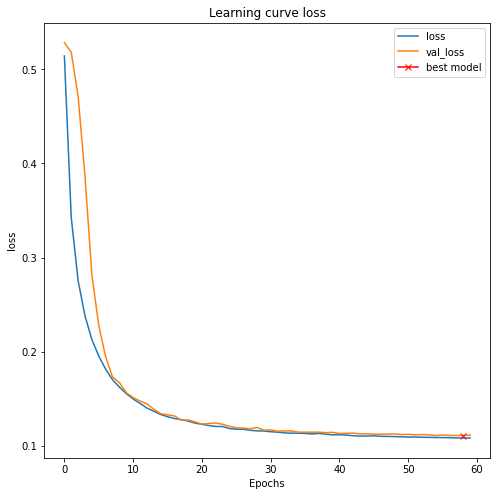

In [45]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve loss")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

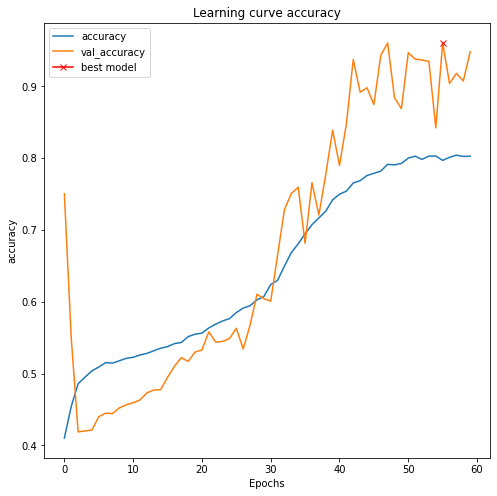

In [46]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve accuracy")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend();

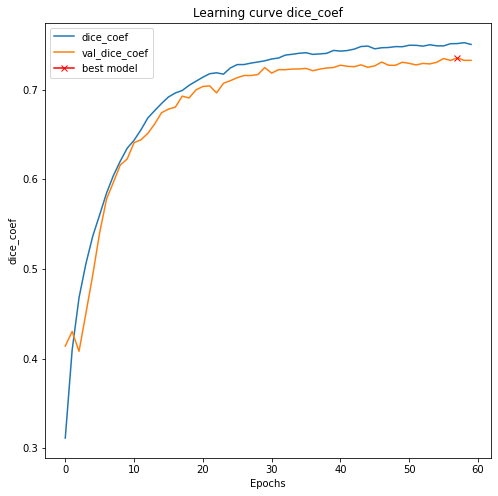

In [47]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve dice_coef")
plt.plot(results.history["dice_coef"], label="dice_coef")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmax(results.history["val_dice_coef"]), np.max(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("dice_coef")
plt.legend();

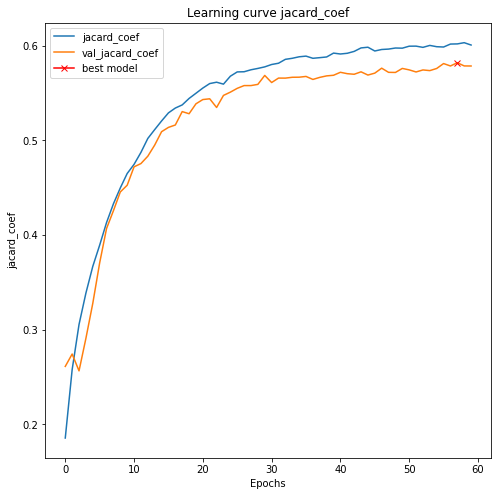

In [48]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve jacard_coef")
plt.plot(results.history["jacard_coef"], label="jacard_coef")
plt.plot(results.history["val_jacard_coef"], label="val_jacard_coef")
plt.plot( np.argmax(results.history["val_jacard_coef"]), np.max(results.history["val_jacard_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("jacard_coef")
plt.legend();

# Evaluation

In [49]:
# # load the best model
# model.load_weights('model.h5')

In [50]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

17/17 [==============================] - 9s 527ms/step - loss: 0.1113 - accuracy: 0.9481 - dice_coef: 0.7289 - jacard_coef: 0.5745


[0.11134593188762665,
 0.9481261968612671,
 0.728929877281189,
 0.5744624137878418]

In [51]:
# Predict on train, val and test
preds_train1 = model.predict(X_train, verbose=1)
preds_val1 = model.predict(X_valid, verbose=1)

17/17 [==============================] - 8s 493ms/step


In [52]:
preds_train1.shape

(2133, 128, 128, 2)

In [53]:
preds_val1.shape

(534, 128, 128, 2)

## Predictions on training set

In [ ]:
# Check if training data looks all right
for i in range(preds_train1.shape[0]):
  print(i)
  plot_sample(X_train, y_train, preds_train1, ix=i)
  plt.show()
  if i >25:
    break

In [ ]:
plot_sample(X_train, y_train, preds_train1)

## Predictions on test set

In [ ]:
# Check if valid data looks all right
for i in range(preds_val1.shape[0]):
  print(i)
  plot_sample(X_valid, y_valid, preds_val1, ix=i)
  plt.show()
  if i > int(preds_val1.shape[0]/2):
    break

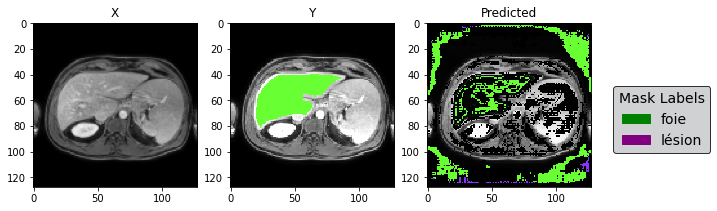

In [95]:
plot_sample(X_valid, y_valid, preds_val1)